# Comparison with different CPU Frequencies

In [1]:
import sys
#print(sys.path)
xx=['/global/common/cori/software/python/2.7-anaconda/lib/python27.zip', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/plat-linux2', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/lib-tk', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/lib-old', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/lib-dynload', '/global/homes/j/jialin/.local/cori/2.7-anaconda/lib/python2.7/site-packages', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/Sphinx-1.4.1-py2.7.egg', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/gtk-2.0', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/setuptools-23.0.0-py2.7.egg', '/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/tabulate-0.7.7-py3.5.egg']
for i in xx:
    sys.path.append(i)
#print(sys.path)


# Parsing and Plotting Functions

In [2]:
#parse bandwidth result, each test is repeated 3 times
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
def parse_line_cpu(txtf): # parse a list of numbers in text file as array
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    x = [int(i.split(':')[1]) for i in x]
    x=np.asarray(x,dtype='float')
    return x
def parse_line_io(txtf): # parse a list of numbers in text file as array
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    x=np.asarray(x)[2:]
    x=np.asarray(x,dtype='float')
    return x
#parse dd perf result
def parse_line_perf(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    ax=list()
    for ix in x:
        if '#' in ix:
            ix = ix.split('#')[1].strip().split(' ')[0].strip('%')
            ax.append(ix)
    ax=np.asarray(ax,dtype='float')
    return ax
def parse_line_perf_raw(txtf): # parse perf result and return an array
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    ax=list()
    for ix in x:
        if '#' in ix:
            ix = ix.split('#')[0].strip().split(' ')[0].strip('%')
            ax.append(ix)
    ax=np.asarray(ax,dtype='float')
    return ax
# Linear Fit and Plot
def plt_fit(has_cpu1,has_io_avg,xlabel=None,ylabel=None): # Linear Fit and plot IO bw with cpu freq
    from scipy import stats
    import sys
    has_cpu1=has_cpu1
    has_io_avg=has_io_avg
    slope, intercept, r_value, p_value, std_err = stats.linregress(has_cpu1,has_io_avg)
    print 'slope:%.2f'%slope
    print 'intercept:%.2f'%intercept
    print 'r-square:%.2f'%(r_value*r_value)
    predict_y = slope*has_cpu1+intercept
    x=has_cpu1
    y=has_io_avg
    pred_error = y - predict_y
    degrees_of_freedom = len(x) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    # Plotting
    plt.plot(x, y, 'o',label='data')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, predict_y, 'k-',label='fitting,r^2=%.2f'%(r_value*r_value))
    plt.legend(loc='upper left')
    plt.show()
    return slope,intercept,r_value*r_value
def plot_hasknl(df_has,df_knl,xt): #plot the IO bw and the cpu freq, knl and has together, plus trubo mode
    df_has_turbo_maxio=pd.to_numeric(df_has.groupby(df_has.index / 3).max()['io'])[0]
    df_knl_turbo_maxio=pd.to_numeric(df_knl.groupby(df_knl.index / 3).max()['io'])[0]
    df_has_turbo_minio=pd.to_numeric(df_has.groupby(df_has.index / 3).min()['io'])[0]
    df_knl_turbo_minio=pd.to_numeric(df_knl.groupby(df_knl.index / 3).min()['io'])[0]
    df_has_turbo_meanio=pd.to_numeric(df_has.groupby(df_has.index / 3).mean()['io'])[0]
    df_knl_turbo_meanio=pd.to_numeric(df_knl.groupby(df_knl.index / 3).mean()['io'])[0]
    print 'Turbo IO BW(MB/s):Haswell:%.2f\tKNL:%.2f\n'%(df_has_turbo_maxio,df_knl_turbo_maxio)
    print "Turbo IO BW Ratio:%.2f\n"%(df_has_turbo_maxio/df_knl_turbo_maxio)
    has_cpumax=df_has.groupby(df_has.index / 3).mean()['ClockRate'].apply(lambda x : round(x,1))[0]
    knl_cpumax=df_knl.groupby(df_knl.index / 3).mean()['ClockRate'].apply(lambda x: round(x,1))[0]
    
    print 'Turbo CPU Frequency(Ghz):Haswell:%.2f\tKNL:%.2f\n'%(has_cpumax,knl_cpumax)
    print 'Turbo CPU Frequency Ratio:%.2f\n'%(has_cpumax/knl_cpumax)

    df_has1=df_has[3:]
    df_knl1=df_knl[3:]
    df_has_mean=pd.to_numeric(df_has1.groupby(df_has1.index / 3).mean()['io'])
    df_has_max=pd.to_numeric(df_has1.groupby(df_has1.index / 3).max()['io'])
    df_has_min=pd.to_numeric(df_has1.groupby(df_has1.index / 3).min()['io'])
    df_knl_mean=pd.to_numeric(df_knl1.groupby(df_knl1.index / 3).mean()['io'])
    df_knl_max=pd.to_numeric(df_knl1.groupby(df_knl1.index / 3).max()['io'])
    df_knl_min=pd.to_numeric(df_knl1.groupby(df_knl1.index / 3).min()['io'])
    mean_ioratio=np.zeros(3)
    for i in (0,1,2):
        mean_ioratio[i]=df_has_mean[i+1]/df_knl_mean[i+1]
    print "Average IO BW Ratio at Same CPU Frequency:%.2f\n"%(np.mean(mean_ioratio))
    allcpu,has_x,knl_x=index_cpu(df_has1,df_knl1)
    all_labels=["{0:.1f}".format(x) for x in allcpu]
    if (allcpu[has_x[0]]>knl_cpumax):
        plt.errorbar(has_x+1,df_has_mean, [df_has_mean-df_has_min, df_has_max-df_has_mean], fmt='--o', label="Haswell")
        plt.errorbar(knl_x+1,df_knl_mean, [df_knl_mean-df_knl_min, df_knl_max-df_knl_mean], fmt='--o', label="KNL")
        plt.errorbar(knl_x[0],df_knl_turbo_meanio,[[df_knl_turbo_meanio-df_knl_turbo_minio, df_knl_turbo_maxio-df_knl_turbo_meanio]],fmt='r*') # turbo knl
        plt.errorbar(0,df_has_turbo_meanio,[[df_has_turbo_meanio-df_has_turbo_minio, df_has_turbo_maxio-df_has_turbo_meanio]],fmt='r*') # turbo knl
        all_labels.insert(0,str(knl_cpumax)) # add the knl's turbo cpu


    else:
        plt.errorbar(has_x+2,df_has_mean, [df_has_mean-df_has_min, df_has_max-df_has_mean], fmt='--o', label="Haswell")
        plt.errorbar(knl_x+2,df_knl_mean, [df_knl_mean-df_knl_min, df_knl_max-df_knl_mean], fmt='--o', label="KNL")
        plt.errorbar(1,df_knl_turbo_meanio,[[df_knl_turbo_meanio-df_knl_turbo_minio, df_knl_turbo_maxio-df_knl_turbo_meanio]],fmt='r*') # turbo knl
        plt.errorbar(0,df_has_turbo_meanio,[[df_has_turbo_meanio-df_has_turbo_minio, df_has_turbo_maxio-df_has_turbo_meanio]],fmt='r*') # turbo knl
    all_labels.insert(0,str(has_cpumax)) # add the haswell's turbo cpu
    total_ticks=len(all_labels)
    plt.xticks(range(total_ticks),all_labels)
    plt.xlabel('CPU Frequencies, GHz, KNL&Haswell, 1.2, 1.3, 1.4, Turbo')#('CPU Frequencies, GHz, KNL: 1.0-1.4, Haswell: 1.2-2.3')
    plt.ylabel('IO Bandwidth (MB/s)')
    plt.title(xt)
    plt.grid(True)
    #setup ylim:
    ylim_max=df_has_turbo_meanio*1.1
    ylim_min=df_knl_min[len(df_knl_min)-1]*0.9
    plt.ylim(ylim_min,ylim_max)
    plt.legend()
    if (allcpu[has_x[0]]>knl_cpumax):
        knltur_x=knl_x[0]
    else:
        knltur_x=1
    plt.annotate('Turbo KNL, %.2fGHz'%knl_cpumax, xy=(knltur_x, df_knl_turbo_meanio), 
                 xytext=(knltur_x, df_knl_turbo_meanio*1.2)
                    )
    plt.annotate('Turbo Haswell, %.2fGHz'%has_cpumax, xy=(0.7, df_has_turbo_meanio), 
                 xytext=(0.7, df_has_turbo_meanio)
                #arrowprops=dict(facecolor='blue', shrink=1),
                )
    
def index_cpu(df_has,df_knl): # First combining all knl and has reported cpu freq, then return the unique cpu freq, and index of knl and has in that unique array
    has_cpu=df_has.groupby(df_has.index / 3).mean()['ClockRate'].apply(lambda x : round(x,1))
    knl_cpu=df_knl.groupby(df_knl.index / 3).mean()['ClockRate'].apply(lambda x: round(x,1))

    has_1cpu=has_cpu.copy()
    has_cpu=has_cpu.append(knl_cpu)
    #print 'has cpu unique:\n',has_cpu.unique()
    search_has=has_1cpu.as_matrix()
    search_knl=knl_cpu.as_matrix()
    master=has_cpu.unique()
    search_has_id=list()
    search_knl_id=list()
    #print 'all cpu:\n',master
    #print 'has cpu:\n',search_has
    #print 'knl cpu:\n',search_knl
    for i in search_has:
        if i in master:
            x=np.where(i==master)[0][0]
            search_has_id.append(x)
    for i in search_knl:
        if i in master:
            x=np.where(i==master)[0][0]
            search_knl_id.append(x)
    return master,np.asarray(search_has_id),np.asarray(search_knl_id)

def plot_same():  # select the cpu-freq that both kNL and Haswell have, e..g, 1.4Ghz, then fit it with it's IO
    for icl in df_has_same.columns:
        (k,b,rs)=plt_fit(df_has_same[icl],df_has_same['io'],icl+'-haswell','IO Bandwidth')
        dic_has[icl]=rs
        (k,b,rs)=plt_fit(df_knl_same[icl],df_knl_same['io'],icl+'-knl','IO Bandwidth')
        dic_knl[icl]=rs
        (k,b,rs)=plt_fit(df_hasknl[icl],df_hasknl['io'],icl+'-hasknl','IO Bandwidth')
        dic_hasknl[icl]=rs
    print "HASWELL"
    for key, value in sorted(dic_has.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "KNL"
    for key, value in sorted(dic_knl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "HASWELL-KNL"
    for key, value in sorted(dic_hasknl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)

def plot_all(): # fit and plot all data for both knl and haswell
    for icl in df_has.columns:
        (k,b,rs)=plt_fit(df_has[icl],df_has['io'],icl+'-haswell','IO Bandwidth')
        dic_has[icl]=rs
        (k,b,rs)=plt_fit(df_knl[icl],df_knl['io'],icl+'-knl','IO Bandwidth')
        dic_knl[icl]=rs
        (k,b,rs)=plt_fit(df_hasknl[icl],df_hasknl['io'],icl+'-hasknl','IO Bandwidth')
        dic_hasknl[icl]=rs
    print "HASWELL"
    for key, value in sorted(dic_has.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "KNL"
    for key, value in sorted(dic_knl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "HASWELL-KNL"
    for key, value in sorted(dic_hasknl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)

# Data Loading and DataFrame Construction Functions

In [3]:
def load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw):
    #parse all files
    knl_cpu=parse_line_cpu(knl_cpu_f)
    has_cpu=parse_line_cpu(has_cpu_f)
    if raw==1:
        knl_perfs=parse_line_perf_raw(knl_perf_f)
        has_perfs=parse_line_perf_raw(has_perf_f)
    else:
        knl_perfs=parse_line_perf(knl_perf_f)
        has_perfs=parse_line_perf(has_perf_f)        
    has_io=parse_line_io(has_io_f)
    knl_io=parse_line_io(knl_io_f)

    #reshaping io and perfs
    knl_perfs=knl_perfs.reshape(-1,8) # there are 8 columns in the perf result, e.g., IPC, context-switch, etc
    has_perfs=has_perfs.reshape(-1,8)

    #calculating mean/max/min
    import numpy as np
    for x in range(len(knl_io)):
        if knl_io[x] < 90:
            knl_io[x]=knl_io[x]*1024
    for x in range(len(has_io)):
        if has_io[x] < 90:
            has_io[x]=has_io[x]*1024
    import pandas as pd
    df_knl=pd.DataFrame(knl_perfs)
    df_has=pd.DataFrame(has_perfs)
    df_knl.columns=['CPUuti','Contxtsw',
                    'cpumig','pageft',
                    'ClockRate','IPC','branch','branchmis']
    df_has.columns=['CPUuti','Contxtsw',
                    'cpumig','pageft',
                    'ClockRate','IPC','branch','branchmis']

    df_knl_cpu=pd.DataFrame({'userset':knl_cpu})
    df_knl=df_knl.join(df_knl_cpu)

    df_has_cpu=pd.DataFrame({'userset':has_cpu})
    df_has=df_has.join(df_has_cpu)

    df_knl_io=pd.DataFrame({'io':knl_io})
    df_knl=df_knl.join(df_knl_io)
    df_has_io=pd.DataFrame({'io':has_io})
    df_has=df_has.join(df_has_io)
    df_has['userset']=df_has['userset'].apply(lambda x : x/1000000.0)
    df_knl['userset']=df_knl['userset'].apply(lambda x : x/1000000.0)
    return df_has,df_knl

# Test 1: 'dd to cscratch' with Page Cache On

In [4]:
#log files, perf detials:
knl_perf_f="../log/dd_cscratch/knl.err"
has_perf_f="../log/dd_cscratch/haswell.err"
#user specified cpu scaling freqs
knl_cpu_f='../log/dd_cscratch/cpu_knl.txt'
has_cpu_f='../log/dd_cscratch/cpu_has.txt'
#observed io bw
has_io_f='../log/dd_cscratch/haswell.3711608.bw'
knl_io_f='../log/dd_cscratch/knl.3711609.bw'
raw=1
(df_has_raw,df_knl_raw)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
raw=0
(df_has,df_knl)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
df_knl_same=df_knl[(df_knl['userset'] <=1.4) & (df_knl['userset'] >=1.2)]
df_has_same=df_has[(df_has['userset'] <=1.4) & (df_has['userset'] >=1.2)]

Turbo IO BW(MB/s):Haswell:1126.40	KNL:326.00

Turbo IO BW Ratio:3.46

Turbo CPU Frequency(Ghz):Haswell:3.40	KNL:1.50

Turbo CPU Frequency Ratio:2.27

Average IO BW Ratio at Same CPU Frequency:3.18



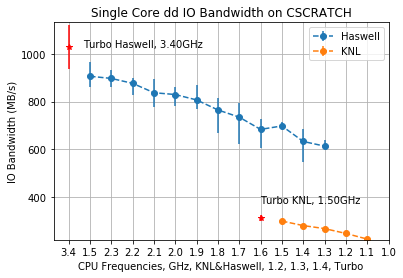

In [5]:
plot_hasknl(df_has,df_knl,"Single Core dd IO Bandwidth on CSCRATCH")

In [6]:
plt.savefig('pageon.eps', format='eps', dpi=1000)
#pdf.savefig('pageon.pdf',format='pdf',dpi=1000)

# IPC Comparison at Same CPU Frequencies

Mean IPC Ratio:2.23
Mean IPC Ratio at Same CPU Freq:2.35
Haswell IPC 	Mean:1.17	Min:1.04	Max:1.28	Std:0.05
KNL IPC 	Mean:0.53	Min:0.50	Max:0.55	Std:0.01


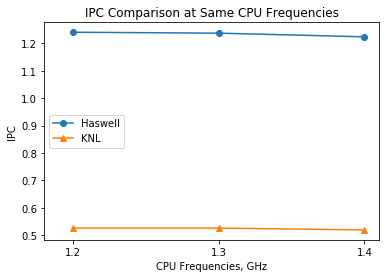

In [7]:
df_has_same_mean=df_has_same.groupby(df_has_same.index / 3).mean()
df_knl_same_mean=df_knl_same.groupby(df_knl_same.index / 3).mean()
df_has_mean=pd.to_numeric(df_has_same_mean['IPC'])
df_knl_mean=pd.to_numeric(df_knl_same_mean['IPC'])
df_has_cpu_mean=pd.to_numeric(df_has_same_mean['ClockRate']).apply(lambda x : round(x,2))
df_knl_cpu_mean=pd.to_numeric(df_knl_same_mean['ClockRate']).apply(lambda x : round(x,2))
plt.xlabel('CPU Frequencies, GHz')
plt.ylabel('IPC')
plt.plot(df_has_cpu_mean,df_has_mean,'o-',label="Haswell")
plt.plot(df_has_cpu_mean,df_knl_mean,'^-',label="KNL")
plt.legend(loc='center left')
plt.xticks(df_has_cpu_mean)
plt.xlim(1.18,1.41)
plt.title('IPC Comparison at Same CPU Frequencies')
#df_has_cpu_mean
print 'Mean IPC Ratio:%.2f'%(df_has['IPC'].mean()/df_knl['IPC'].mean())

print 'Mean IPC Ratio at Same CPU Freq:%.2f'%(df_has_same['IPC'].mean()/df_knl_same['IPC'].mean())
print "Haswell IPC \tMean:%.2f\tMin:%.2f\tMax:%.2f\tStd:%.2f"%(df_has['IPC'].mean(),df_has['IPC'].min(),df_has['IPC'].max(),df_has['IPC'].std())
print "KNL IPC \tMean:%.2f\tMin:%.2f\tMax:%.2f\tStd:%.2f"%(df_knl['IPC'].mean(),df_knl['IPC'].min(),df_knl['IPC'].max(),df_knl['IPC'].std())

# IO~CPU Frequencies on Haswell

slope:278.29
intercept:286.11
r-square:0.79


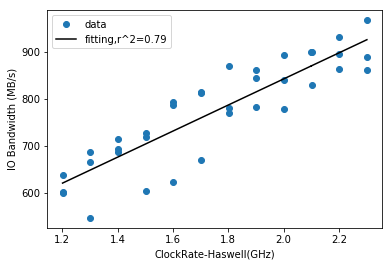

slope:201.30
intercept:415.31
r-square:0.76


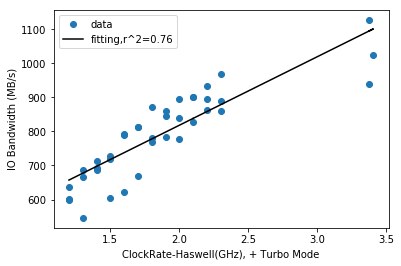

(201.30315647922006, 415.3132503758967, 0.76211345180699763)

In [8]:
plt_fit(df_has['ClockRate'][3:],df_has['io'][3:],'ClockRate-Haswell(GHz)','IO Bandwidth (MB/s)')
plt_fit(df_has['ClockRate'],df_has['io'],'ClockRate-Haswell(GHz), + Turbo Mode','IO Bandwidth (MB/s)')

# IO~CPU Frequencies on KNL

slope:184.33
intercept:41.28
r-square:0.95


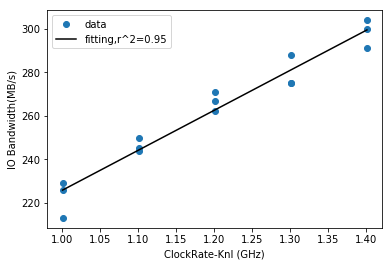

slope:172.95
intercept:54.19
r-square:0.94


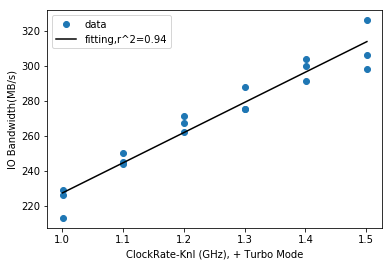

(172.95238095238096, 54.192126984126929, 0.93910171103563933)

In [9]:
plt_fit(df_knl['ClockRate'][3:],df_knl['io'][3:],'ClockRate-Knl (GHz)','IO Bandwidth(MB/s)')
plt_fit(df_knl['ClockRate'],df_knl['io']
        ,'ClockRate-Knl (GHz), + Turbo Mode','IO Bandwidth(MB/s)')

In [10]:
# Regression Analysis 

In [12]:
#df_hasknl
from sklearn.decomposition import PCA
pca =PCA(n_components=4)
#pca.fit(df_hasknl)
#IPC + cpu-mig(K/sec) + pageft(K/sec) + ClockRate(Ghz) + branch(M/sec) + branchmis(%)

In [13]:
# Regression KNL and Haswell together

In [15]:
import statsmodels.api as sm
from patsy import dmatrices
#y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_hasknl, return_type='dataframe')
#mod = sm.OLS(y, X)
#result=mod.fit()
#print result.summary()

In [16]:
# Regression Haswell only

In [17]:
y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_has, return_type='dataframe')
mod = sm.OLS(y, X)
result=mod.fit()
#print result.summary()

In [18]:
# Regression KNL only

In [19]:
y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_knl, return_type='dataframe')
mod = sm.OLS(y, X)
result=mod.fit()
#print result.summary()

In [20]:
## Conclusion 1: KNL's single IO performance is more correlated with CPU frequencies than Haswell, r-square 0.94> 0.76
## Conclusion 2: With same CPU frequencies, the IO performance ratio between Haswell and KNL: 2.26
## Conclusion 3: The single core peak IO performance ratio between Haswell and KNL: 3.32

# Test 2 'dd to null' with Page Cache On

In [21]:
#log files, perf detials:
knl_perf_f="../log/dd_null//knl.err"
has_perf_f="../log/dd_null/has.err"
#user specified cpu scaling freqs
knl_cpu_f='../log/dd_null/cpu_knl.txt'
has_cpu_f='../log/dd_null/cpu_has.txt'
#observed io bw
has_io_f='../log/dd_null/null.haswell.3827241.bw'
knl_io_f='../log/dd_null/null.knl.3827242.bw'
raw=1
(df_has_null_raw,df_knl_null_raw)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
raw=0
(df_has_null,df_knl_null)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
df_knl_null_same=df_knl_null[(df_knl_null['userset'] <=1.4) & (df_knl_null['userset'] >=1.2)]
df_has_null_same=df_has_null[(df_has_null['userset'] <=1.4) & (df_has_null['userset'] >=1.2)]

Mean IPC Ratio at Same CPU Freq:2.05
Haswell IPC 	Mean:2.64	Min:2.40	Max:2.97	Std:0.10
KNL IPC 	Mean:1.30	Min:1.30	Max:1.30	Std:0.00


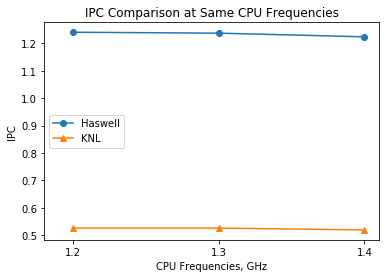

In [22]:
df_has_same_mean=df_has_same.groupby(df_has_null_same.index / 3).mean()
df_knl_same_mean=df_knl_same.groupby(df_knl_null_same.index / 3).mean()
df_has_mean=pd.to_numeric(df_has_same_mean['IPC'])
df_knl_mean=pd.to_numeric(df_knl_same_mean['IPC'])
df_has_cpu_mean=pd.to_numeric(df_has_same_mean['ClockRate']).apply(lambda x : round(x,2))
df_knl_cpu_mean=pd.to_numeric(df_knl_same_mean['ClockRate']).apply(lambda x : round(x,2))
plt.xlabel('CPU Frequencies, GHz')
plt.ylabel('IPC')
plt.plot(df_has_cpu_mean,df_has_mean,'o-',label="Haswell")
plt.plot(df_has_cpu_mean,df_knl_mean,'^-',label="KNL")
plt.legend(loc='center left')
plt.xticks(df_has_cpu_mean)
plt.xlim(1.18,1.41)
plt.title('IPC Comparison at Same CPU Frequencies')
#df_has_cpu_mean
print 'Mean IPC Ratio at Same CPU Freq:%.2f'%(df_has_null_same['IPC'].mean()/df_knl_null_same['IPC'].mean())
print "Haswell IPC \tMean:%.2f\tMin:%.2f\tMax:%.2f\tStd:%.2f"%(df_has_null['IPC'].mean(),df_has_null['IPC'].min(),df_has_null['IPC'].max(),df_has_null['IPC'].std())
print "KNL IPC \tMean:%.2f\tMin:%.2f\tMax:%.2f\tStd:%.2f"%(df_knl_null['IPC'].mean(),df_knl_null['IPC'].min(),df_knl_null['IPC'].max(),df_knl_null['IPC'].std())

In [23]:
length_cscratch=len(df_has_null_raw)
a=np.arange(0,length_cscratch)
#plt.plot(a,df_has_raw['ClockRate'],'r',label='cscratch')
#plt.plot(a,df_has_null_raw['ClockRate'],'b',label='null')
#plt.legend()
#plt.ylabel('Cycles')
#plt.title('Haswell Cycles with dd to null vs. cscratch')

In [24]:
length_cscratch=len(df_knl_raw)
a=np.arange(0,length_cscratch)
#plt.plot(a,df_knl_raw['ClockRate'],'r',label='cscratch')
#plt.plot(a,df_knl_null_raw['ClockRate'],'b',label='null')
#plt.legend()
#plt.ylabel('Cycles')
#plt.title('KNL Cycles with dd to null vs. cscratch')

In [25]:
length_null=len(df_knl_null_raw)
length_cscratch=len(df_knl_raw)
assert(length_null==length_cscratch)
a=np.arange(0,length_cscratch)
#plt.plot(a,df_knl_raw['IPC'],'r',label='cscratch')
#plt.plot(a,df_knl_null_raw['IPC'],'b',label='null')
#plt.legend()
#plt.ylabel('Instructions')
#plt.title('KNL Instructions with dd to null vs. cscratch')

In [26]:
length_null=len(df_has_null_raw)
length_cscratch=len(df_has_raw)
assert(length_null==length_cscratch)
a=np.arange(0,length_cscratch)
#plt.plot(a,df_has_raw['IPC'],'r',label='cscratch')
#plt.plot(a,df_has_null_raw['IPC'],'b',label='null')
#plt.legend()
#plt.ylabel('Instructions')
#plt.title('Haswell Instructions with dd to null vs. cscratch')

In [27]:
# Conclusion 4 when writting to dev/null, much less number of instructions and cycles are produced

In [28]:
length_has=len(df_has_raw)
#assert(length_null==length_cscratch)
a=np.arange(0,length_has)
length_knl=len(df_knl_raw)
#assert(length_null==length_cscratch)
b=np.arange(0,length_knl)
#plt.plot(27+b,df_knl_raw['ClockRate'],'r',label='KNL-cycles')
#plt.plot(a,df_has_raw['ClockRate'],'b',label='Haswell-cycles')
#plt.legend(loc='center left')
#plt.ylabel('Cycles')
#plt.title('KNL vs. Haswell Cycles with dd cscratch')

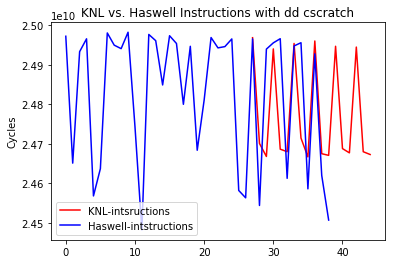

In [30]:
length_has=len(df_has_raw)
#assert(length_null==length_cscratch)
a=np.arange(0,length_has)
length_knl=len(df_knl_raw)
#assert(length_null==length_cscratch)
b=np.arange(0,length_knl)
#print a
plt.plot(27+b,df_knl_raw['IPC'],'r',label='KNL-intsructions')
plt.plot(a,df_has_raw['IPC'],'b',label='Haswell-intstructions')
plt.legend(loc='left')
plt.ylabel('Cycles')
plt.title('KNL vs. Haswell Instructions with dd cscratch')

In [31]:
# Try to compile on KNL, to see if there is any instruction difference, and IO difference

# Test 3 'hdf5 io to cscratch' with Page Cache On

In [32]:
#log files, perf detials:
knl_perf_f="../log/h5/knl.err"
has_perf_f="../log/h5/haswell.err"
#user specified cpu scaling freqs
knl_cpu_f='../log/h5/cpu_knl.txt'
has_cpu_f='../log/h5/cpu_has.txt'
#observed io bw
has_io_f='../log/h5/haswell.4029892.bw'
knl_io_f='../log/h5/knl.4029891.bw'
raw=1
(df_has_h5_raw,df_knl_h5_raw)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
raw=0
(df_has_h5,df_knl_h5)=load_data(knl_perf_f,has_perf_f,knl_cpu_f,has_cpu_f,has_io_f,knl_io_f,raw)
df_knl_h5_same=df_knl_h5[(df_knl_h5['userset'] <=1.4) & (df_knl_h5['userset'] >=1.2)]
df_has_h5_same=df_has_h5[(df_has_h5['userset'] <=1.4) & (df_has_h5['userset'] >=1.2)]

Turbo IO BW(MB/s):Haswell:1064.96	KNL:348.16

Turbo IO BW Ratio:3.06

Turbo CPU Frequency(Ghz):Haswell:3.50	KNL:1.50

Turbo CPU Frequency Ratio:2.33

Average IO BW Ratio at Same CPU Frequency:2.65



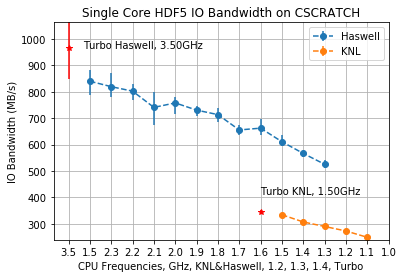

In [33]:
plot_hasknl(df_has_h5,df_knl_h5,"Single Core HDF5 IO Bandwidth on CSCRATCH")

In [34]:
#plot_hasknl(df_has,df_knl,"Single Core dd IO Bandwidth on CSCRATCH")

Mean IPC Ratio:1.88
Mean IPC Ratio at Same CPU Freq:1.93
Haswell IPC 	Mean:1.49	Min:1.36	Max:1.55	Std:0.04
KNL IPC 	Mean:0.79	Min:0.78	Max:0.81	Std:0.01


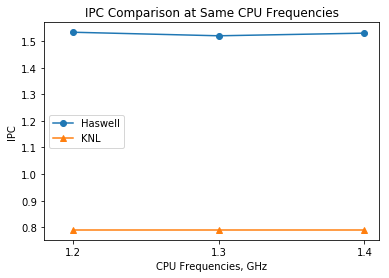

In [35]:
df_has_same_mean=df_has_h5_same.groupby(df_has_h5_same.index / 3).mean()
df_knl_same_mean=df_knl_h5_same.groupby(df_knl_h5_same.index / 3).mean()
df_has_mean=pd.to_numeric(df_has_same_mean['IPC'])
df_knl_mean=pd.to_numeric(df_knl_same_mean['IPC'])
df_has_cpu_mean=pd.to_numeric(df_has_same_mean['ClockRate']).apply(lambda x : round(x,2))
df_knl_cpu_mean=pd.to_numeric(df_knl_same_mean['ClockRate']).apply(lambda x : round(x,2))
plt.xlabel('CPU Frequencies, GHz')
plt.ylabel('IPC')
plt.plot(df_has_cpu_mean,df_has_mean,'o-',label="Haswell")
plt.plot(df_has_cpu_mean,df_knl_mean,'^-',label="KNL")
plt.legend(loc='center left')
plt.xticks(df_has_cpu_mean)
plt.xlim(1.18,1.41)
plt.title('IPC Comparison at Same CPU Frequencies')
#df_has_cpu_mean
print 'Mean IPC Ratio:%.2f'%(df_has_h5['IPC'].mean()/df_knl_h5['IPC'].mean())

print 'Mean IPC Ratio at Same CPU Freq:%.2f'%(df_has_h5_same['IPC'].mean()/df_knl_h5_same['IPC'].mean())
print "Haswell IPC \tMean:%.2f\tMin:%.2f\tMax:%.2f\tStd:%.2f"%(df_has_h5['IPC'].mean(),df_has_h5['IPC'].min(),df_has_h5['IPC'].max(),df_has_h5['IPC'].std())
print "KNL IPC \tMean:%.2f\tMin:%.2f\tMax:%.2f\tStd:%.2f"%(df_knl_h5['IPC'].mean(),df_knl_h5['IPC'].min(),df_knl_h5['IPC'].max(),df_knl_h5['IPC'].std())

# IO~CPU Frequencies on Haswell

slope:272.11
intercept:225.54
r-square:0.89


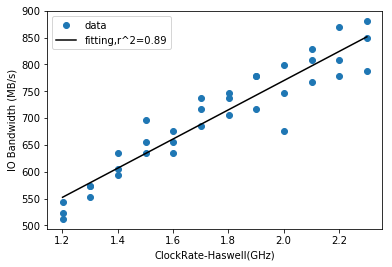

(272.11188811188805, 225.54097280497291, 0.89023495279617537)

In [36]:
plt_fit(df_has_h5['ClockRate'][3:],df_has_h5['io'][3:],'ClockRate-Haswell(GHz)','IO Bandwidth (MB/s)')
#plt_fit(df_has_h5['ClockRate'],df_has_h5['io'],'ClockRate-Haswell(GHz), + Turbo Mode','IO Bandwidth (MB/s)')

# IO~CPU Frequencies on KNL

slope:204.80
intercept:44.85
r-square:0.96


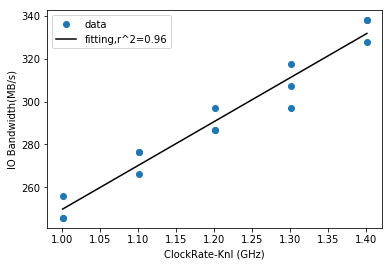

(204.79999999999993, 44.851200000000119, 0.9554140127388534)

In [37]:
plt_fit(df_knl_h5['ClockRate'][3:],df_knl_h5['io'][3:],'ClockRate-Knl (GHz)','IO Bandwidth(MB/s)')
#plt_fit(df_knl_h5['ClockRate'],df_knl_h5['io']
#        ,'ClockRate-Knl (GHz), + Turbo Mode','IO Bandwidth(MB/s)')

# About Different Dataframe

In [38]:
#df_has
#df_has_same  # same cpu freq, 1.4, 1,3, 1.2 on has and knl
#df_knl_same
#df_knl speed, e.g., IPC: instruction per cycle

#df_has_raw # absolute value, e.g., total instructions in column IPC
#df_knl_raw
#df_has_h5  # hdf5 mpi independent io test
#df_knl_h5
#df_has_h5_raw
#df_knl_h5_raw
#df_has_h5_same
#df_knl_h5_same

In [39]:
#df_knl

# Test 4 'dd to cscratch' with Dsync IO

In [40]:
knl_cpu=[1.497,1.497,1.497,1.395,1.395,1.395,1.297,1.298,1.298,1.198,1.198,1.198]
has_cpu=[3.316,3.302,3.289,1.379,1.380,1.379,1.286,1.287,1.287,1.196,1.196,1.196]
knl_io=[31.3,29.2,29.3,28.1,28.4,30.6,27.0,30.8,27.9,29.0,28.8,22.8]
has_io=[45.6,35.7,45.7,38.5,40.5,36.1,38.1,38.0,39.2,33.5,37.5,41.5]
knl_cpu=np.asarray(knl_cpu[3:]) #cut the turbo mode
knl_io=np.asarray(knl_io[3:])
has_cpu=np.asarray(has_cpu[3:])
has_io=np.asarray(has_io[3:])


9
9
slope:11.05
intercept:13.83
r-square:0.16


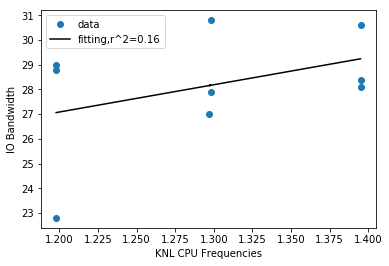

28.1555555556
38.1
1.35319652723


In [41]:
import numpy as np
a=np.arange(0,len(knl_io))
print len(knl_cpu)
print len(knl_io)
plt_fit(knl_cpu,knl_io, xlabel='KNL CPU Frequencies',ylabel='IO Bandwidth')
#plt.plot(a,has_io,label='Haswell dsync')
#plt.legend()
print np.average(knl_io)
print np.average(has_io)
print np.average(has_io)/np.average(knl_io)

slope:4.76
intercept:31.98
r-square:0.03


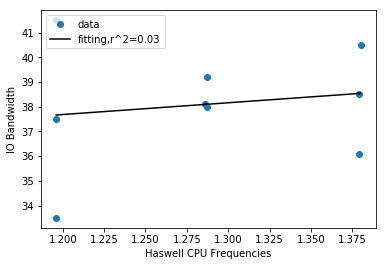

(4.7560491868306212, 31.977379346820044, 0.025791510515648639)

In [42]:
plt_fit(has_cpu,has_io, xlabel='Haswell CPU Frequencies',ylabel='IO Bandwidth')


In [43]:
knl_cpu=[1.497,1.497,1.497,1.395,1.395,1.395,1.297,1.298,1.298,1.198,1.198,1.198]
has_cpu=[3.316,3.302,3.289,1.379,1.380,1.379,1.286,1.287,1.287,1.196,1.196,1.196]
knl_io=[31.3,29.2,29.3,28.1,28.4,30.6,27.0,30.8,27.9,29.0,28.8,22.8]
has_io=[45.6,35.7,45.7,38.5,40.5,36.1,38.1,38.0,39.2,33.5,37.5,41.5]
#knl_cpu=np.asarray(knl_cpu) #cut the turbo mode
#knl_io=np.asarray(knl_io)
#has_cpu=np.asarray(has_cpu)
#has_io=np.asarray(has_io)

df_knl_cacheOff=pd.DataFrame({"ClockRate":knl_cpu,"io":knl_io})  # 1st row as the column names
df_has_cacheOff=pd.DataFrame({"ClockRate":has_cpu,"io":has_io})  # 1st row as the column names

In [44]:
#df_knl_cacheOff

In [45]:
#df_has_cacheOff

In [46]:
#plot_hasknl(df_has_cacheOff,df_knl_cacheOff,
#            "Single Core dd IO Bandwidth on CSCRATCH, dsync",shift_has=1,shift_knl=1) # shift is the offset to same freq

In [47]:
#plot_hasknl(df_has,df_knl,"Single Core dd IO Bandwidth on CSCRATCH, PageCache:Off",shift_has=9,shift_knl=1) # shift is the offset to same freq

Turbo IO BW(MB/s):Haswell:45.70	KNL:31.30

Turbo IO BW Ratio:1.46

Turbo CPU Frequency(Ghz):Haswell:3.30	KNL:1.50

Turbo CPU Frequency Ratio:2.20

Average IO BW Ratio at Same CPU Frequency:1.35



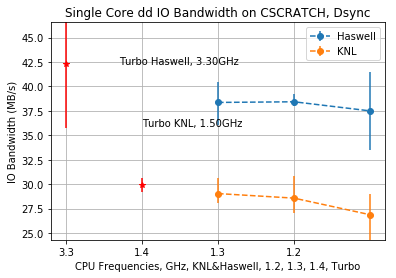

In [48]:
plot_hasknl(df_has_cacheOff,df_knl_cacheOff,
            "Single Core dd IO Bandwidth on CSCRATCH, Dsync") # shift is the offset to same freq

# Test 5 'dd to cscratch' with Direct IO